In [1]:
# Set the number of GPU-device
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
# some imports
import sys
import warnings
warnings.filterwarnings("ignore")

from copy import copy

import numpy as np
from numpy.random import default_rng
from scipy.special import binom
from scipy.ndimage.morphology import binary_fill_holes, binary_dilation

sys.path.append('../../..')

from seismiqb import *

from seismiqb.batchflow import FilesIndex

In [3]:
def bezier_figure(key_points_amount=7, radius=0.2, sharpness=0.05, scale=1.0, plot_size=(1, 1), 
                  resolution=None, unscaled_points_distance=.5, points_search_stop_iter=100, seed=None):
    """ Bezier closed curve coordinates.        
    Creates Bezier closed curve which passes through random points.
    Code based on:  https://stackoverflow.com/questions/50731785/create-random-shape-contour-using-matplotlib    

    Parameters
    ----------
    key_points_amount : int
        Amount of angles (key points) in the random figure.
        Must be more than 1.
    radius : float
        Distance for control middle points in Bezier algorithm. 
        Is a number between 0 and 1.
    sharpness : float
        Degree of sharpness/edgy.
        If 0 then a curve will be the smoothest.
    scale : float
        Figure scale. 
        Is a number between 0 and 1. Fits to the plot_size.
    plot_size : sequence int
        Size of plotting area.
    resolution : int
        Amount of points in one curve between two key points.
    unscaled_points_distance : float
        Distance between all key points in a unit square.
        A number between 0 and 1.
    points_search_stop_iter : int
        Stop criterion for search of key points.
    seed: int, optional
        Seed the random numbers generator.
    """
    rand_gen = default_rng(seed)
    resolution = resolution or int(scale*max(plot_size)*100)
    
    # Get key points of figure as random points which are far enough each other        
    key_points = rand_gen.random((key_points_amount, 2))
    unscaled_points_distance = unscaled_points_distance**2
    
    for i in range(points_search_stop_iter):
        # Found distances between points and sort key_points by angles         
        shifted_points = key_points - np.mean(key_points, axis=0)
        angles = np.arctan2(shifted_points[:, 0], shifted_points[:, 1])
        key_points = key_points[np.argsort(angles)]

        squared_distances = np.sum(np.diff(key_points, axis=0)**2, axis=1)
        if np.all(squared_distances >= unscaled_points_distance):
            break
        key_points = rand_gen.random((key_points_amount, 2))

    key_points *= scale*np.array(plot_size, float)
    key_points = np.vstack([key_points, key_points[0]]) 

    # Calculate figure angles in key points
    p = np.arctan(sharpness) / np.pi + .5
    diff_between_points = np.diff(key_points, axis=0)
    angles = np.arctan2(diff_between_points[:, 1], diff_between_points[:, 0])    
    angles = angles + 2*np.pi*(angles < 0)
    rolled_angles = np.roll(angles, 1)
    angles = p*angles + (1 - p)*rolled_angles + np.pi*(np.abs(rolled_angles - angles) > np.pi)
    angles = np.append(angles, angles[0])        

    # Create figure part by part: make curves between each pair of points
    curve_segments = []
    # Calculate control points for Bezier curve
    points_distances = np.sqrt(np.sum(diff_between_points**2, axis=1))
    radii = radius*points_distances
    middle_control_points_1 = np.transpose(radii*[np.cos(angles[:-1]), 
                                                  np.sin(angles[:-1])]) + key_points[:-1]
    middle_control_points_2 = np.transpose(radii*[np.cos(angles[1:] + np.pi), 
                                                  np.sin(angles[1:] + np.pi)]) + key_points[1:]
    curve_main_points_arr = np.hstack([key_points[:-1], middle_control_points_1,
                                       middle_control_points_2, key_points[1:]]).reshape(key_points_amount, 4, -1)
    
    # Get Bernstein polynomial approximation of each curve
    for i in range(key_points_amount):
        bezier_param_t = np.linspace(0, 1, num=resolution)            
        current_segment = np.zeros((resolution, 2))
        for point_num, point in enumerate(curve_main_points_arr[i]):
            polynomial_degree = np.power(bezier_param_t, point_num)
            polynomial_degree *= np.power(1 - bezier_param_t, 3 - point_num)
            bernstein_polynomial = binom(3, point_num)*polynomial_degree
            current_segment += np.outer(bernstein_polynomial, point)
        curve_segments.extend(current_segment)
        
    curve_segments = np.array(curve_segments)
    figure_coordinates = np.unique(np.ceil(curve_segments).astype(int), axis=0)
    return figure_coordinates 

In [4]:
def salty_noise(noise_level, locations, seed=None):
    """ Generate salty noise near locations.
    
    Parameters
    ----------
    noise_level : int
        Radius of noise scattering near the locations.
    locations : ndarray
        An array of locations in the vicinity of which noise should be sampled.
    seed : int, optional
        Seed the random numbers generator.
    """
    rand_gen = default_rng(seed)
    noise = rand_gen.normal(loc=locations, 
                            scale=noise_level, 
                            size=locations.shape)
    return np.unique(np.vstack([locations, noise.astype(int)]), axis=0)

In [5]:
def make_objects_suitable_for_plotting_area(horizon, locations, shift=True):
    """ Shift and cut objects in plotting area.
    
    Parameters
    ----------
    horizon
        Instance of Horizon class.
    locations : ndarray
        An array of objects locations.
    shift : bool
        Whether to shift figures to plotting area.
    """
    #Shift figure in plotting area
    if shift:
        horizon_shape = horizon.shape
        nonzero_borders_shift = np.min(locations, axis=0)
        nonzero_borders_shift[nonzero_borders_shift > 0] = 0
        up_borders_shift = np.max(locations, axis=0)
        up_borders_shift[up_borders_shift <= horizon_shape] = 0
        up_borders_shift[up_borders_shift > horizon_shape] -= np.array(horizon_shape)[up_borders_shift > horizon_shape]
        locations -= (up_borders_shift + nonzero_borders_shift + 1)

    # Cut figure if it is too big
    suited_x = (locations[:, 0] < horizon.i_length) & (locations[:, 0] >= 0)
    suited_y = (locations[:, 1] < horizon.x_length) & (locations[:, 1] >= 0)
    locations = locations[suited_x & suited_y]
    return locations

In [6]:
def random_figures(horizon, n=10, noise_level=0, scale=1.0, max_scale=0.25, 
                   max_angles_amount=4, max_sharpness=5, locations=None, seed=None):
    """ Create matrix of random figured holes for horizon.        
   
    Parameters
    ----------
    horizon
        Instance of Horizon class.
    n : int
        Amount of figured holes on horizon.
    noise_level : int
        Radius of noise scattering near the borders of figures.
    scale : float or sequence of float
        If float, each figure will have a random scale from exponential distribution with parameter scale.
        If sequence, each figure will have a provided scale.
    max_scale : int
        Maximum figure scale.
    max_angles_amount : int
        Maximum amount of angles in each figure.
    max_sharpness : float
        Maximum value of figures sharpness.
    locations : ndarray
        If provided, an array of desired locations of figures.
    seed : int, optional
        Seed the random numbers generator.
    """  
    rand_gen = default_rng(seed)
    horizon_shape = horizon.shape
    filtering_matrix = np.zeros_like(horizon.matrix)
    
    if isinstance(scale, float):
        figures_scale = []
        probability_of_preferable_values = 1 - np.exp(-scale*max_scale)
        sampling_scale = np.ceil(1.0 / probability_of_preferable_values).astype(int)
        while len(figures_scale) < n:
            new_scale = rand_gen.exponential(scale, size=(n-len(figures_scale))*sampling_scale)
            new_scale = new_scale[new_scale < max_scale]
            figures_scale.extend(new_scale)
        scale = figures_scale[:n]
        
    if locations is None:
        # Choice random traces
        locations_idxs = rand_gen.choice(horizon.points.shape[0], size=n)
        locations = horizon.points[locations_idxs, :2]

    for location, figure_scale in zip(locations, scale):
        key_points_amount = rand_gen.integers(2, max_angles_amount+1)
        radius = rand_gen.random()
        sharpness = rand_gen.random()*rand_gen.integers(1, max_sharpness)
        
        figure_coordinates = bezier_figure(key_points_amount, radius, sharpness, figure_scale, horizon_shape, seed=seed)
        figure_coordinates += location
               
        if noise_level:
            figure_coordinates = salty_noise(noise_level, figure_coordinates, seed=None)
        
        figure_coordinates = make_objects_suitable_for_plotting_area(horizon, figure_coordinates)
        filtering_matrix[figure_coordinates[:, 0], figure_coordinates[:, 1]] = 1
    filtering_matrix = binary_fill_holes(filtering_matrix)
    filtering_matrix = horizon.put_on_full(filtering_matrix, False)
    return filtering_matrix

In [7]:
def add_noise(horizon, n=5e-5, shape=1, noise_level=0, seed=None):
    """ Create matrix of random point holes for horizon.        
   
    Parameters
    ----------
    horizon
        Instance of Horizon class.
    n : float
        Proportion of point holes on the horizon. A number between 0 and 1.
    shape : int or sequence of int
        Shape of points.
    noise_level : int
        Radius of noise scattering near the borders of figures.
    seed : int, optional
        Seed the random numbers generator.
    """
    rand_gen = default_rng(seed)
    filtering_matrix = np.zeros_like(horizon.matrix)
    n = int(horizon.size*n)
    x = rand_gen.integers(0, horizon.i_length, n)
    y = rand_gen.integers(0, horizon.x_length, n)
    
    filtering_matrix[x, y] = 1
    if isinstance(shape, int):
        shape = (shape, shape)
    filtering_matrix = binary_dilation(filtering_matrix, np.ones(shape))
    if noise_level:
        points_coordinates = np.argwhere(filtering_matrix == 1)
        points_coordinates = salty_noise(noise_level, points_coordinates, seed=None)
        points_coordinates = make_objects_suitable_for_plotting_area(horizon, points_coordinates)
        filtering_matrix[points_coordinates[:, 0], points_coordinates[:, 1]] = 1
    filtering_matrix = horizon.put_on_full(filtering_matrix, False)
    return filtering_matrix

# Load horizon

In [8]:
cube_path = "/data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP.hdf5"
horizon_dir = '/data/seismic_data/seismic_interpretation/CUBE_01_ETP/INPUTS/HORIZONS/RAW/etp_B_anon'

In [9]:
dsi = FilesIndex(path=[cube_path], no_ext=True)
dataset = SeismicCubeset(dsi)

dataset.load(horizon_dir)
dataset.create_labels({dataset.indices[0]: [horizon_dir]})
dataset.modify_sampler(dst='train_sampler', finish=True)

geometry = dataset.geometries[0]
horizon = dataset.labels[0][0]

In [10]:
init_horizon_copy = horizon.__copy__()

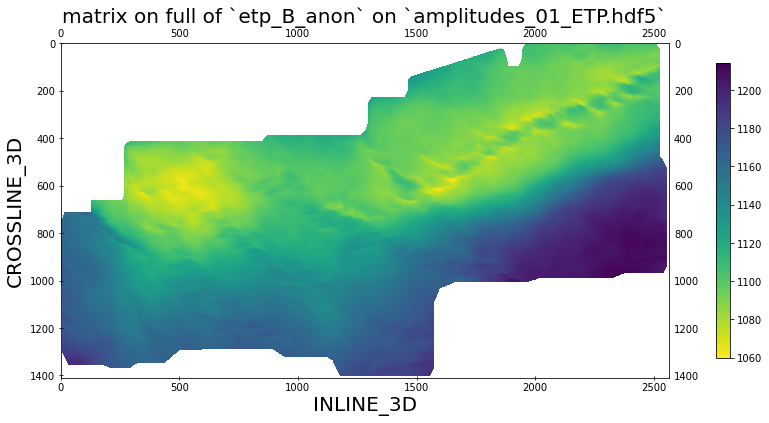

In [11]:
horizon.show()

# Simple random figures

In [12]:
%%time
filtering_matrix = random_figures(horizon, n=20, noise_level=0, scale=1.0, locations=None, seed=0)

CPU times: user 1.19 s, sys: 17.5 ms, total: 1.21 s
Wall time: 1.21 s


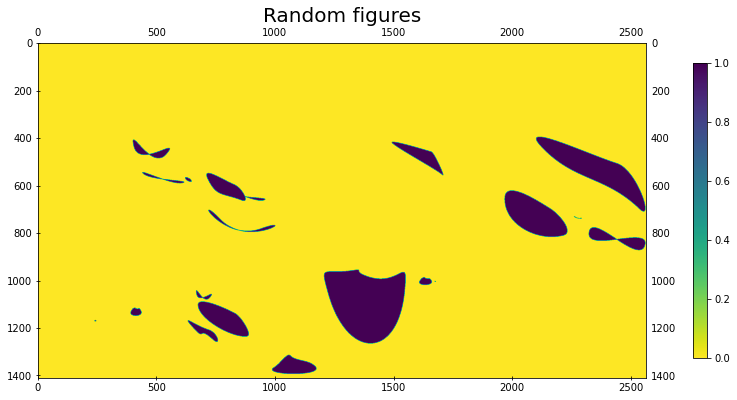

In [13]:
plot_image(filtering_matrix, title="Random figures")

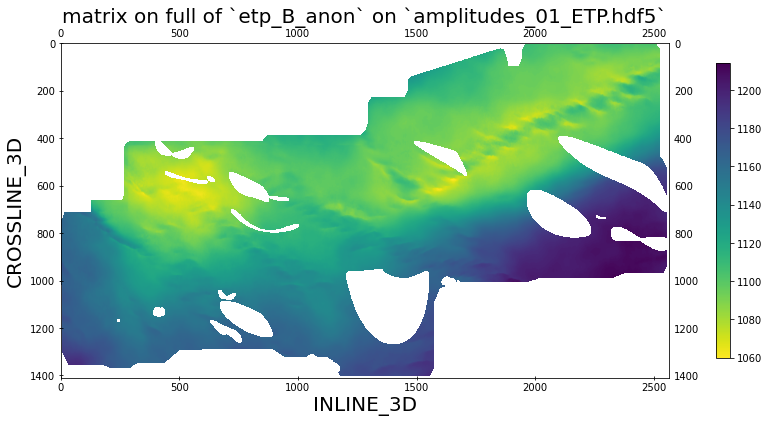

In [14]:
horizon.filter(filtering_matrix=filtering_matrix)
horizon.show()

# Noisy random figures

In [15]:
horizon = init_horizon_copy.__copy__()

In [16]:
%%time
filtering_matrix = random_figures(horizon, n=20, noise_level=25, scale=1.0, locations=None, seed=0)

CPU times: user 1.24 s, sys: 25.6 ms, total: 1.27 s
Wall time: 1.27 s


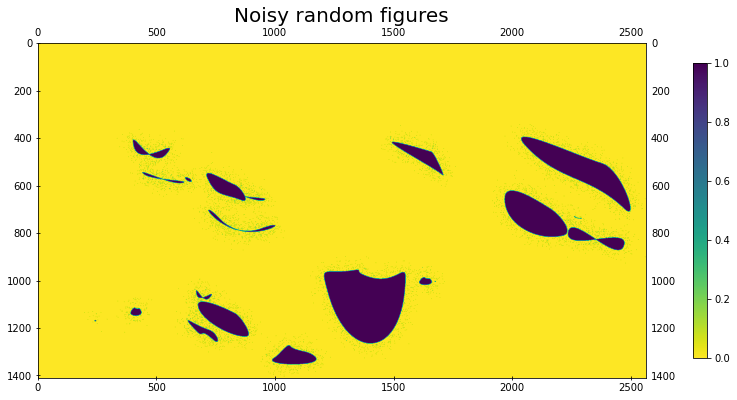

In [17]:
plot_image(filtering_matrix, title="Noisy random figures")

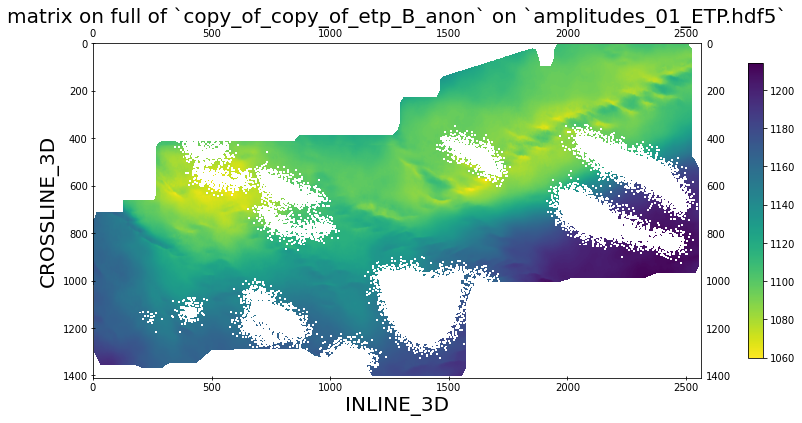

In [18]:
horizon.filter(filtering_matrix=filtering_matrix)
horizon.show()

# Noisy random figures and point holes

In [19]:
horizon = init_horizon_copy.__copy__()

In [20]:
%%time
filtering_matrix1 = random_figures(horizon, n=20, noise_level=25, scale=1.0, locations=None, seed=0)
filtering_matrix2 = add_noise(horizon, shape=5, noise_level=3, seed=0)
filtering_matrix = filtering_matrix1 + filtering_matrix2

CPU times: user 1.38 s, sys: 24.3 ms, total: 1.4 s
Wall time: 1.4 s


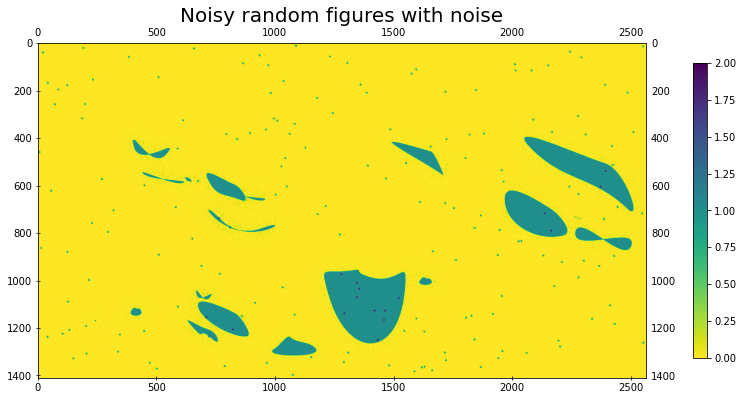

In [21]:
plot_image(filtering_matrix, title="Noisy random figures with noise")

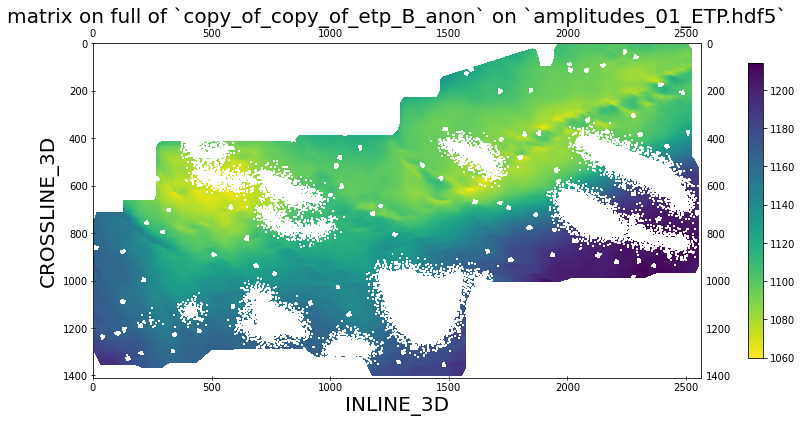

In [22]:
horizon.filter(filtering_matrix=filtering_matrix)
horizon.show()